Load Dataset

In [2]:
import os, re, random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

import tensorflow as tf
print("TF version:", tf.__version__)

# Reproducible
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)

TF version: 2.19.0


In [3]:
CANDIDATE_PATHS = [
    "data_komentar_lengkap.csv"
]

FILE_PATH = None
for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        FILE_PATH = p
        break

if FILE_PATH is None:
    raise FileNotFoundError(
        "File data_komentar_lengkap.csv tidak ditemukan.\n"
        "Letakkan file di /content atau Google Drive lalu sesuaikan CANDIDATE_PATHS."
    )

print("✅ Membaca file dari:", FILE_PATH)
df = pd.read_csv(FILE_PATH)

print("Shape:", df.shape)
print("Kolom:", df.columns.tolist())
df.head()


✅ Membaca file dari: data_komentar_lengkap.csv
Shape: (3106, 4)
Kolom: ['author', 'ulasan', 'like', 'publis']


,author,ulasan,like,publis
0,@alizaenal01,"Desain gag mirip, bagus nih modelnya, iphon Bo...",0,2025-12-21T16:32:53Z
1,@nopeli747,Harga 18juta sd 22 jutaan tu di shoopie edan😅😅😅😅😅,0,2025-12-21T13:54:26Z
2,@atangnurhayat8086,xiaomi nyenggol Iphone mulai dari kardusnya 😂😂😂😂,0,2025-12-21T11:58:34Z
3,@sulissulis1162,Kameranya ada bias atau pantulan cahaya nyakh?...,0,2025-12-21T11:34:56Z
4,@rionindyo8826,"Gaji masih UMR harga HP udh puluhan juta.,🥲",0,2025-12-21T07:41:53Z


Preprocessing + Cleaning

In [4]:
def clean_text(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#\w+", " ", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Pastikan kolom teks ada
if "ulasan" not in df.columns:
    raise ValueError("Kolom 'ulasan' tidak ditemukan di CSV.")

df["text"] = df["ulasan"].astype(str).apply(clean_text)
df = df[df["text"].str.len() > 0].copy()

print("Jumlah data setelah bersih:", len(df))


Jumlah data setelah bersih: 3064


4. Minimal Jumlah Data 3000

In [5]:
assert len(df) >= 3000, f"❌ Data kurang dari 3000! Saat ini: {len(df)}"
print("✅ Lolos: jumlah data >= 3000")


✅ Lolos: jumlah data >= 3000


3. Membuat 3 kelas label

In [6]:
pos_words = set([
    "bagus","mantap","keren","suka","hebat","worth","murah","oke","ok","baik",
    "mantep","gokil","top","recommended","rekomendasi","best","sip","juara","ngebut",
    "cakep","kenceng","puas","inovasi"
])

neg_words = set([
    "jelek","buruk","lemot","mahal","bohong","parah","zonk","cacat","rusak","error",
    "overheat","panas","ngelag","lag","benci","mengecewakan","kecewa","ampas","payah",
    "menyesal"
])

def label_sentiment(text: str) -> str:
    toks = text.split()
    pos = sum(t in pos_words for t in toks)
    neg = sum(t in neg_words for t in toks)
    if pos > neg:
        return "positif"
    elif neg > pos:
        return "negatif"
    return "netral"

df["label_str"] = df["text"].apply(label_sentiment)

print(df["label_str"].value_counts())
assert df["label_str"].nunique() >= 3, "❌ Kelas kurang dari 3. Tambahkan kosakata label."
print("✅ Lolos: minimal 3 kelas")


label_str
netral     2591
positif     382
negatif      91
Name: count, dtype: int64
✅ Lolos: minimal 3 kelas


Split Train/Test

In [7]:
label2id = {"negatif": 0, "netral": 1, "positif": 2}
id2label = {v:k for k,v in label2id.items()}

X = df["text"].values
y = df["label_str"].map(label2id).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train:", len(X_train), "Test:", len(X_test))


Train: 2451 Test: 613


5. 3 Percobaan Skema Pelatihan Berbeda

Percobaan 1 : BiLSTM

In [8]:
import numpy as np
import tensorflow as tf

# Reproducible
SEED = 42
tf.keras.utils.set_random_seed(SEED)

max_tokens = 20000
seq_len = 80
batch_size = 32
epochs = 8

# Dataset tf.data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test,  y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Word-level vectorization
textvec_word = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=seq_len
)
textvec_word.adapt(X_train)

model_bilstm = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    textvec_word,
    tf.keras.layers.Embedding(max_tokens, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist_bilstm = model_bilstm.fit(train_ds, validation_data=test_ds, epochs=epochs, verbose=1)

train_acc_bilstm = hist_bilstm.history["accuracy"][-1]
_, test_acc_bilstm = model_bilstm.evaluate(test_ds, verbose=0)

print("\n=== HASIL Percobaan 1 (BiLSTM) ===")
print("Train acc:", round(train_acc_bilstm*100, 2), "%")
print("Test  acc:", round(test_acc_bilstm*100, 2), "%")


Epoch 1/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8023 - loss: 0.6436 - val_accuracy: 0.8450 - val_loss: 0.4658
Epoch 2/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8650 - loss: 0.3903 - val_accuracy: 0.9054 - val_loss: 0.3013
Epoch 3/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9489 - loss: 0.1395 - val_accuracy: 0.9250 - val_loss: 0.3408
Epoch 4/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9732 - loss: 0.0722 - val_accuracy: 0.9331 - val_loss: 0.3536
Epoch 5/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9965 - loss: 0.0124 - val_accuracy: 0.9315 - val_loss: 0.3921
Epoch 6/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9364 - val_loss: 0.4566
Epoch 7/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 6.9244e-04 - val_accuracy: 0.9364 - val_loss: 0.4685
Epoch 8/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 3.7638e-04 - val_accuracy: 0.9364 - v

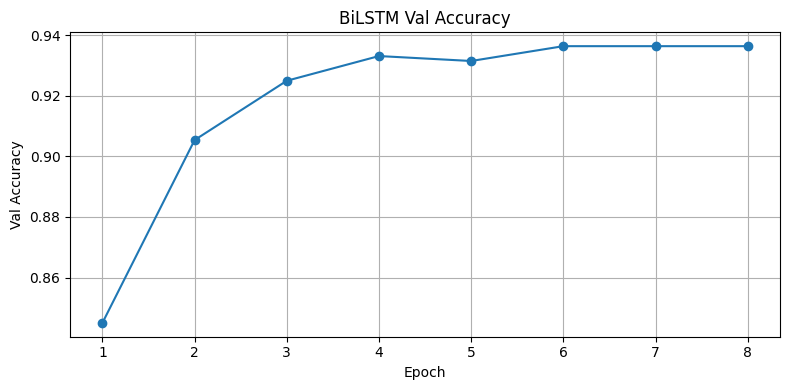

In [9]:
import matplotlib.pyplot as plt

val_acc = hist_bilstm.history.get("val_accuracy", [])
epochs_range = range(1, len(val_acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, val_acc, marker="o")
plt.title("BiLSTM Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.xticks(list(epochs_range))
plt.grid(True)
plt.tight_layout()
plt.show()


Percobaan 2 : CNN - Char

In [10]:
tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(SEED)

max_chars = 120      # panjang urutan karakter
char_vocab = 120     # kapasitas vocab karakter
epochs_cnn = 8

# Char-level vectorization
textvec_char = tf.keras.layers.TextVectorization(
    max_tokens=char_vocab,
    output_mode="int",
    output_sequence_length=max_chars,
    split="character"
)
textvec_char.adapt(X_train)

model_cnn_char = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    textvec_char,
    tf.keras.layers.Embedding(char_vocab, 64),
    tf.keras.layers.Conv1D(128, 5, activation="relu"),
    tf.keras.layers.Conv1D(128, 5, activation="relu"),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

model_cnn_char.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

hist_cnn = model_cnn_char.fit(train_ds, validation_data=test_ds, epochs=epochs_cnn, verbose=1)

train_acc_cnn = hist_cnn.history["accuracy"][-1]
_, test_acc_cnn = model_cnn_char.evaluate(test_ds, verbose=0)

print("\n=== HASIL Percobaan 2 (CNN-char) ===")
print("Train acc:", round(train_acc_cnn*100, 2), "%")
print("Test  acc:", round(test_acc_cnn*100, 2), "%")


Epoch 1/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8161 - loss: 0.6486 - val_accuracy: 0.8450 - val_loss: 0.4892
Epoch 2/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8517 - loss: 0.4840 - val_accuracy: 0.8450 - val_loss: 0.4819
Epoch 3/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8517 - loss: 0.4727 - val_accuracy: 0.8450 - val_loss: 0.4803
Epoch 4/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8520 - loss: 0.4581 - val_accuracy: 0.8483 - val_loss: 0.4575
Epoch 5/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8580 - loss: 0.4216 - val_accuracy: 0.8711 - val_loss: 0.3666
Epoch 6/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8808 - loss: 0.3454 - val_accuracy: 0.9103 - val_loss: 0.2814
Epoch 7/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9152 - loss: 0.2568 - val_accuracy: 0.9315 - val_loss: 0.2421
Epoch 8/8
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9348 - loss: 0.2246 - val_accuracy: 0.9331 - val_loss: 0.232

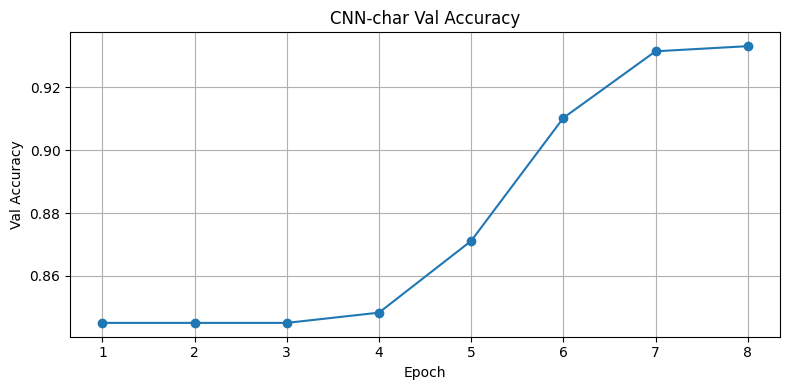

In [18]:
import matplotlib.pyplot as plt

val_acc = hist_cnn.history.get("val_accuracy", [])
epochs_range = range(1, len(val_acc) + 1)

plt.figure(figsize=(8, 4))
plt.plot(epochs_range, val_acc, marker="o")
plt.title("CNN-char Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Val Accuracy")
plt.xticks(list(epochs_range))
plt.grid(True)
plt.tight_layout()
plt.show()


Percobaan 3 : SVM + TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,2),
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

svm = LinearSVC(random_state=SEED)
svm.fit(X_train_tfidf, y_train)

y_train_pred = svm.predict(X_train_tfidf)
y_test_pred  = svm.predict(X_test_tfidf)

train_acc_svm = accuracy_score(y_train, y_train_pred)
test_acc_svm  = accuracy_score(y_test, y_test_pred)

print("\n=== HASIL Percobaan 3 (SVM + TF-IDF) ===")
print("Train acc:", round(train_acc_svm*100, 2), "%")
print("Test  acc:", round(test_acc_svm*100, 2), "%")



=== HASIL Percobaan 3 (SVM + TF-IDF) ===
Train acc: 99.92 %
Test  acc: 95.27 %


Val accuracy per fold: [95.11 91.63 93.06 95.71 92.45]
Mean val acc: 93.59 %


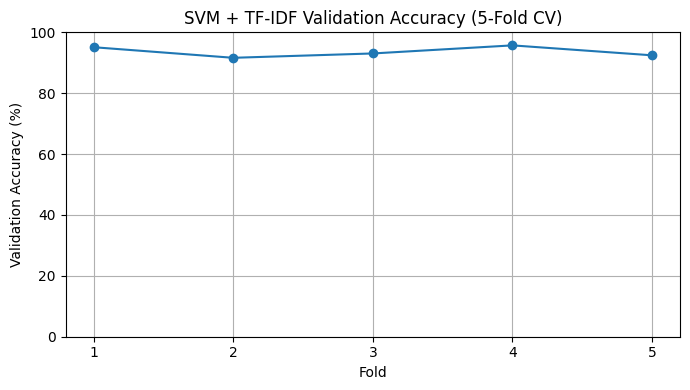

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

fold_acc = []
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_tfidf, y_train), 1):
    X_tr, X_val = X_train_tfidf[tr_idx], X_train_tfidf[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    clf = LinearSVC(random_state=SEED)
    clf.fit(X_tr, y_tr)
    pred_val = clf.predict(X_val)
    acc_val = accuracy_score(y_val, pred_val)
    fold_acc.append(acc_val)

fold_acc = np.array(fold_acc)

print("Val accuracy per fold:", (fold_acc*100).round(2))
print("Mean val acc:", round(fold_acc.mean()*100, 2), "%")

# Plot val accuracy per fold
plt.figure(figsize=(7,4))
plt.plot(range(1, len(fold_acc)+1), fold_acc*100, marker="o")
plt.title("SVM + TF-IDF Validation Accuracy (5-Fold CV)")
plt.xlabel("Fold")
plt.ylabel("Validation Accuracy (%)")
plt.xticks(range(1, len(fold_acc)+1))
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


Classification Report tiap percobaan

In [12]:
from sklearn.metrics import classification_report

# BiLSTM pred
y_pred_bilstm = np.argmax(model_bilstm.predict(test_ds, verbose=0), axis=1)
print("\n[REPORT] BiLSTM\n", classification_report(y_test, y_pred_bilstm, target_names=[id2label[i] for i in range(3)]))

# CNN-char pred
y_pred_cnn = np.argmax(model_cnn_char.predict(test_ds, verbose=0), axis=1)
print("\n[REPORT] CNN-char\n", classification_report(y_test, y_pred_cnn, target_names=[id2label[i] for i in range(3)]))

# SVM report (y_test_pred sudah ada)
print("\n[REPORT] SVM\n", classification_report(y_test, y_test_pred, target_names=[id2label[i] for i in range(3)]))



[REPORT] BiLSTM
               precision    recall  f1-score   support

     negatif       0.75      0.33      0.46        18
      netral       0.95      0.98      0.96       518
     positif       0.87      0.79      0.83        77

    accuracy                           0.94       613
   macro avg       0.86      0.70      0.75       613
weighted avg       0.93      0.94      0.93       613


[REPORT] CNN-char
               precision    recall  f1-score   support

     negatif       1.00      0.28      0.43        18
      netral       0.94      0.98      0.96       518
     positif       0.85      0.78      0.81        77

    accuracy                           0.93       613
   macro avg       0.93      0.68      0.74       613
weighted avg       0.93      0.93      0.93       613


[REPORT] SVM
               precision    recall  f1-score   support

     negatif       1.00      0.44      0.62        18
      netral       0.95      0.99      0.97       518
     positif       0.9

Rekap Akurasi

In [13]:
import pandas as pd
import numpy as np

print("=== NOMOR 3: REKAP KELAS ===")
jumlah_kelas = df["label_str"].nunique()
kelas_counts = df["label_str"].value_counts()

print("Jumlah kelas:", jumlah_kelas)
rekap_no3 = pd.DataFrame({
    "Kelas": kelas_counts.index,
    "Jumlah": kelas_counts.values,
    "Persentase (%)": (kelas_counts.values / kelas_counts.values.sum() * 100).round(2)
})
display(rekap_no3)

status_no3 = "✅ LULUS (>=3 kelas)" if jumlah_kelas >= 3 else "❌ BELUM (kelas < 3)"
print("Status Nomor 3:", status_no3)


# =========================
# NOMOR 2 & 5: REKAP AKURASI 3 PERCOBAAN
# Pastikan variabel ini sudah ada:
# train_acc_bilstm, test_acc_bilstm
# train_acc_cnn,    test_acc_cnn
# train_acc_svm,    test_acc_svm
# =========================
print("\n=== NOMOR 2 & 5: REKAP AKURASI ===")

def pass85(x):
    return "✅" if x >= 0.85 else "❌"

rekap_no2_no5 = pd.DataFrame([
    {
        "Percobaan (Nomor 5)": "1) BiLSTM",
        "Train Acc (%)": round(float(train_acc_bilstm) * 100, 2),
        "Test Acc (%)":  round(float(test_acc_bilstm)  * 100, 2),
        "Train >=85% (No.2)": pass85(float(train_acc_bilstm)),
        "Test  >=85% (No.2)": pass85(float(test_acc_bilstm)),
    },
    {
        "Percobaan (Nomor 5)": "2) CNN-char",
        "Train Acc (%)": round(float(train_acc_cnn) * 100, 2),
        "Test Acc (%)":  round(float(test_acc_cnn)  * 100, 2),
        "Train >=85% (No.2)": pass85(float(train_acc_cnn)),
        "Test  >=85% (No.2)": pass85(float(test_acc_cnn)),
    },
    {
        "Percobaan (Nomor 5)": "3) SVM (TF-IDF)",
        "Train Acc (%)": round(float(train_acc_svm) * 100, 2),
        "Test Acc (%)":  round(float(test_acc_svm)  * 100, 2),
        "Train >=85% (No.2)": pass85(float(train_acc_svm)),
        "Test  >=85% (No.2)": pass85(float(test_acc_svm)),
    },
])

display(rekap_no2_no5)

# Status kelulusan Nomor 2 (minimal: train & test >= 85% untuk tiap percobaan)
all_train_pass = (rekap_no2_no5["Train >=85% (No.2)"] == "✅").all()
all_test_pass  = (rekap_no2_no5["Test  >=85% (No.2)"] == "✅").all()

print("\nStatus Nomor 2 (Train >=85% untuk semua percobaan):", "✅ LULUS" if all_train_pass else "❌ BELUM")
print("Status Nomor 2 (Test  >=85% untuk semua percobaan):", "✅ LULUS" if all_test_pass else "❌ BELUM")


=== NOMOR 3: REKAP KELAS ===
Jumlah kelas: 3


,Kelas,Jumlah,Persentase (%)
0,netral,2591,84.56
1,positif,382,12.47
2,negatif,91,2.97


Status Nomor 3: ✅ LULUS (>=3 kelas)

=== NOMOR 2 & 5: REKAP AKURASI ===


,Percobaan (Nomor 5),Train Acc (%),Test Acc (%),Train >=85% (No.2),Test >=85% (No.2)
0,1) BiLSTM,100.00,93.64,✅,✅
1,2) CNN-char,93.31,93.31,✅,✅
2,3) SVM (TF-IDF),99.92,95.27,✅,✅



Status Nomor 2 (Train >=85% untuk semua percobaan): ✅ LULUS
Status Nomor 2 (Test  >=85% untuk semua percobaan): ✅ LULUS


diagram Rekap Akurasi No 2 & 5

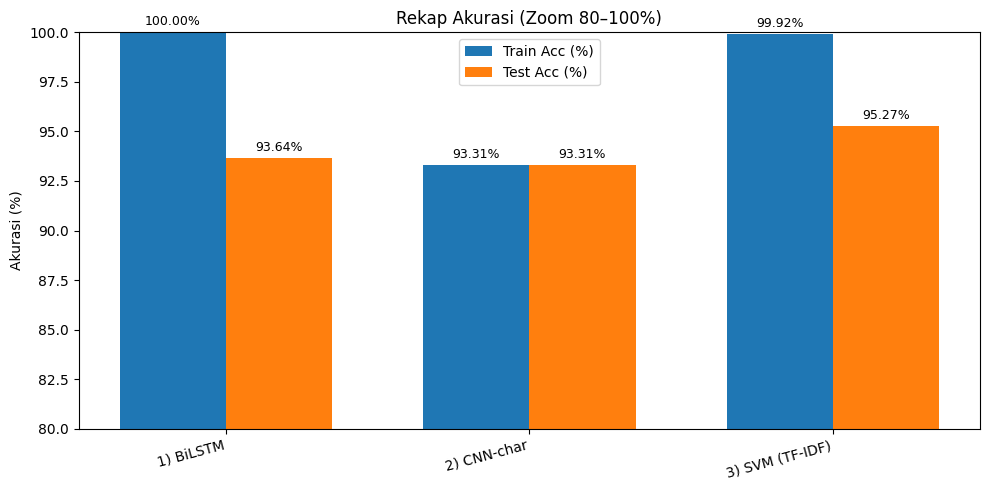

In [14]:
labels = rekap_no2_no5["Percobaan (Nomor 5)"].tolist()
train_vals = rekap_no2_no5["Train Acc (%)"].values
test_vals  = rekap_no2_no5["Test Acc (%)"].values

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(10,5))
b1 = plt.bar(x - w/2, train_vals, width=w, label="Train Acc (%)")
b2 = plt.bar(x + w/2, test_vals,  width=w, label="Test Acc (%)")

plt.xticks(x, labels, rotation=15, ha="right")
plt.ylabel("Akurasi (%)")
plt.title("Rekap Akurasi (Zoom 80–100%)")
plt.ylim(80, 100)

for bars in [b1, b2]:
    for bar in bars:
        h = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, h + 0.2, f"{h:.2f}%", ha="center", va="bottom", fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()



diagram Rekap Akurasi No 3

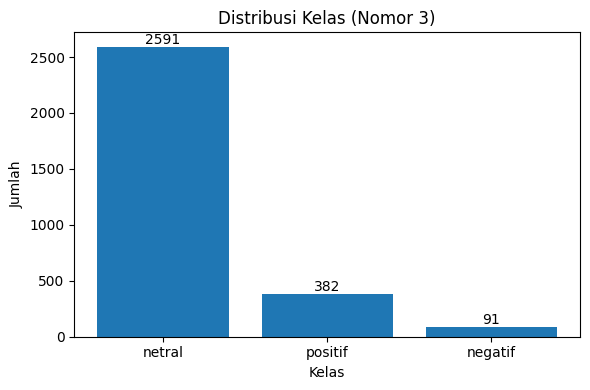

In [15]:
import matplotlib.pyplot as plt

kelas_counts = df["label_str"].value_counts()

plt.figure(figsize=(6,4))
bars = plt.bar(kelas_counts.index, kelas_counts.values)
plt.title("Distribusi Kelas (Nomor 3)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h, str(int(h)), ha="center", va="bottom")

plt.tight_layout()
plt.show()


In [20]:
!pip freeze > requirements.txt

In [21]:
from google.colab import files
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>